## Import common libs
Most of the code in this notebook needs these imports

In [1]:
import cv2
import glob
import random
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from scipy.ndimage.measurements import label

from skimage.feature import hog

%matplotlib inline

## Download Training Data

In [2]:
import urllib.request
import shutil
import zipfile

# Download the training data
data_file_url=r"https://s3.amazonaws.com/udacity-sdc/Vehicle_Tracking/vehicles.zip"
data_file_name=r"/vehicles.zip"
data_file_dir=r"./training_data"

with urllib.request.urlopen(data_file_url) as response, open(data_file_name, 'wb') as out_file:
    shutil.copyfileobj(response, out_file)

# Extract the training data
zip_ref = zipfile.ZipFile(data_file_name, 'r')
zip_ref.extractall(data_file_dir)
zip_ref.close()

data_file_url=r"https://s3.amazonaws.com/udacity-sdc/Vehicle_Tracking/non-vehicles.zip"
data_file_name=r"/non-vehicles.zip"
data_file_dir=r"./training_data"

with urllib.request.urlopen(data_file_url) as response, open(data_file_name, 'wb') as out_file:
    shutil.copyfileobj(response, out_file)

# Extract the training data
zip_ref = zipfile.ZipFile(data_file_name, 'r')
zip_ref.extractall(data_file_dir)
zip_ref.close()

## Load Training Data

Number of car examples:  8792
Number of non-car examples:  8992
Image size:  (64, 64, 3)
Image data type:  float32


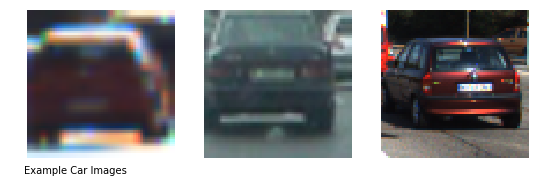

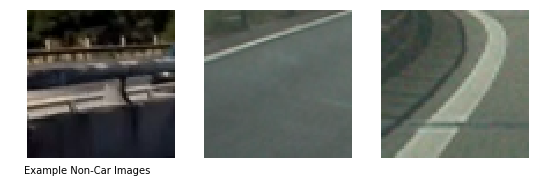

In [3]:
# Read in our vehicles and non-vehicles
cars = []
notcars = []

images = glob.glob('./training_data/vehicles/*/*.png')
for image in images:
    cars.append(image)
    
# shuffle the training data
random.shuffle(cars)

images = glob.glob('./training_data/non-vehicles/*/*.png')
for image in images:
    notcars.append(image)
    
# shuffle the training data
random.shuffle(notcars)

def training_image_info(car_list):
    image_info = {}
    # Read in a test image, either car or notcar
    example_img = mpimg.imread(car_list[0])
    # Define a key "image_shape" and store the test image shape 3-tuple
    image_info["image_shape"] = example_img.shape
    # Define a key "data_type" and store the data type of the test image.
    image_info["data_type"] = example_img.dtype
    # Return data_dict
    return image_info

image_info = training_image_info(cars)

print('Number of car examples: ', len(cars))
print('Number of non-car examples: ', len(notcars))
print('Image size: ', image_info["image_shape"])
print('Image data type: ', image_info["data_type"])

fig, axes = plt.subplots(ncols=3, figsize=(9, 3))
for sample_idx in range(3):
    rand_image_idx = np.random.randint(0, len(cars))
    car_image = mpimg.imread(cars[rand_image_idx])
    axes[sample_idx].imshow(car_image)
    axes[sample_idx].axis('off')
fig.text(0.12, 0.09, 'Example Car Images')
plt.show()

fig, axes = plt.subplots(ncols=3, figsize=(9, 3))
for sample_idx in range(3):
    rand_image_idx = np.random.randint(0, len(notcars))
    non_car_image = mpimg.imread(notcars[rand_image_idx])
    axes[sample_idx].imshow(non_car_image)
    axes[sample_idx].axis('off')
fig.text(0.12, 0.09, 'Example Non-Car Images')
plt.show()

## Utilities

In [4]:
# Color converter
def convert_color(img, color_space='YCrCb'):
    """ Covert from RGB to various color spaces
    """
    if color_space != 'RGB':
        if color_space == 'YCrCb':
            return cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
        if color_space == 'HSV':
            return cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            return cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            return cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            return cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
    else:
        return np.copy(img)

# Function to draw bounding boxes
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    
    # Return the image copy with boxes drawn
    return imcopy


# Function that takes an image,
# start and stop positions in both x and y, 
# window size (x and y dimensions),  
# and overlap fraction (for both x and y)
def slide_window(img, 
                 x_start_stop=[None, None], y_start_stop=[None, None], 
                 xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None: x_start_stop[0] = 0
    if x_start_stop[1] == None: x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None: y_start_stop[0] = 0
    if y_start_stop[1] == None: y_start_stop[1] = img.shape[0]
        
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    
    # Initialize a list to append window positions to
    window_list = []
    
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    
    # Return the list of windows
    return window_list

## HOG features
Utility to extract HOG features

In [5]:
# Two implmentations: sklearn and OpenCV.   My hope was the OpenCV one
# would be much faster, but it wasn't... and it had lower accuracy.

def get_hog_features(img, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=True):
    """ Get HOG features using "sklearn"
    """
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)
        return features

def get_cv_hog_features(img, orient, pix_per_cell, cell_per_block, feature_vec=True):
    """ Get HOG features using OpenCV
    """
    
    # OpenCV requires image pixel values
    # be integers, 0-255
    im = (img * 255).astype(np.uint8)
    
    cell_size = (pix_per_cell, pix_per_cell)
    block_size = (cell_per_block, cell_per_block)
    nbins = orient

    hogWinSize = (img.shape[1] // cell_size[1] * cell_size[1],
                  img.shape[0] // cell_size[0] * cell_size[0])
    
    hogBlockSize = (cell_size[1] * block_size[1],
                    cell_size[0] * block_size[0])
    
    hogBlockStride = (cell_size[1], cell_size[0])
    
    hogCellSize = (cell_size[1], cell_size[0])
    
    hog = cv2.HOGDescriptor(hogWinSize, hogBlockSize, hogBlockStride, hogCellSize, nbins)
    
    h = hog.compute(im)
    
    if feature_vec == False:
        n_cells = (img.shape[0] // cell_size[0], img.shape[1] // cell_size[1])
        new_shape = (n_cells[1] - block_size[1] + 1,
                     n_cells[0] - block_size[0] + 1,
                     block_size[0], block_size[1], nbins)
        h = h.reshape(new_shape).transpose((1, 0, 2, 3, 4))
        
    return h


### Display example HOG output

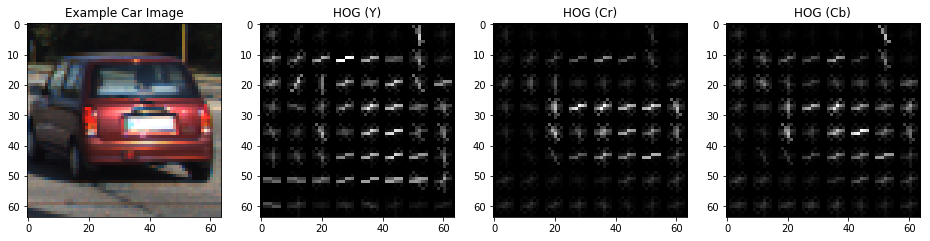

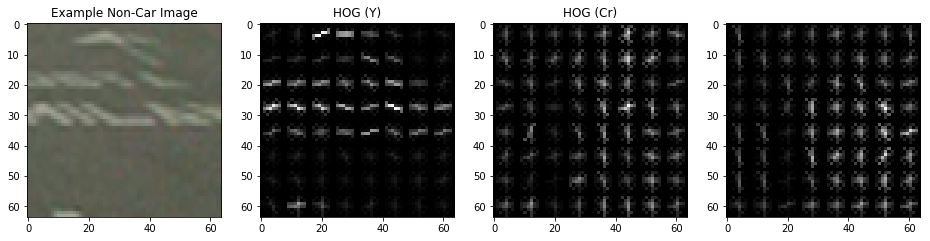

In [6]:
car_image = mpimg.imread('test_images/training_example.png')
non_car_image = mpimg.imread('test_images/non_car_example.png')

def hog_example(image_file_name, color_space="YCrCb"):
    orig_image = mpimg.imread(image_file_name)
    conv_image = convert_color(orig_image, color_space)
    
    # Define HOG parameters
    orient = 9
    pix_per_cell = 8
    cell_per_block = 2
    # Call our function with vis=True to see an image output
    features0, hog_image_0 = get_hog_features(conv_image[:,:,0],
                                             orient,
                                             pix_per_cell,
                                             cell_per_block,
                                             vis=True,
                                             feature_vec=True)
    
    features1, hog_image_1 = get_hog_features(conv_image[:,:,1],
                                             orient,
                                             pix_per_cell,
                                             cell_per_block,
                                             vis=True,
                                             feature_vec=True)
    
    features2, hog_image_2 = get_hog_features(conv_image[:,:,2],
                                             orient,
                                             pix_per_cell,
                                             cell_per_block,
                                             vis=True,
                                             feature_vec=True)
    
    return orig_image, (features0, features1, features2), (hog_image_0, hog_image_1, hog_image_2)

# Plot example car image
orig_image, hog_features, hog_images = hog_example('test_images/training_example.png')
fig, axes = plt.subplots(ncols=4, figsize=(16, 9))
axes[0].imshow(orig_image)
axes[0].set_title('Example Car Image')
axes[1].imshow(hog_images[0], cmap="gray")
axes[1].set_title('HOG (Y)')
axes[2].imshow(hog_images[1], cmap="gray")
axes[2].set_title('HOG (Cr)')
axes[3].imshow(hog_images[2], cmap="gray")
axes[3].set_title('HOG (Cb)')

# Plot example non-car image
orig_image, hog_features, hog_images = hog_example('test_images/non_car_example.png')
fig, axes = plt.subplots(ncols=4, figsize=(16, 9))
axes[0].imshow(orig_image)
axes[0].set_title('Example Non-Car Image')
axes[1].imshow(hog_images[0], cmap="gray")
axes[1].set_title('HOG (Y)')
axes[2].imshow(hog_images[1], cmap="gray")
axes[2].set_title('HOG (Cr)')
axes[3].imshow(hog_images[2], cmap="gray")



# Color features
Utilities to extract features based on color.

In [7]:
# color_hist: concatenated histograms of each color chanel's values
def color_hist(img, nbins=32, bins_range=(0, 256), vis=False):
    """ Compute the histogram of the color channels separately
    """
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    
    if vis == True:
        # Generating bin centers
        bin_edges = channel1_hist[1]
        bin_centers = (bin_edges[1:]  + bin_edges[0:len(bin_edges)-1])/2
        return hist_features, channel1_hist, channel2_hist, channel3_hist, bin_centers
    else:
        return hist_features

# bin_spatial: essentially the flattened,
# color image after resizing.
def bin_spatial(img, size=(32, 32)):
    """ Compute binned color features
    """
    features = cv2.resize(img, size).ravel()
    return features


### Display example Color features

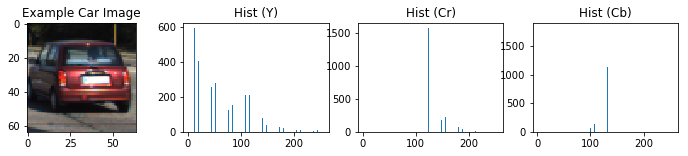

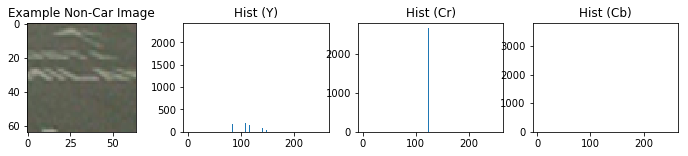

In [8]:
orig_image = mpimg.imread('test_images/training_example.png')
img = cv2.cvtColor(orig_image, cv2.COLOR_RGB2YCrCb)
image = (img * 255)
feature_vec, ch1_h, ch2_h, ch3_h, bincen = color_hist(image, nbins=32, bins_range=(0, 256), vis=True)

fig, axes = plt.subplots(ncols=4, figsize=(12, 2))
axes[0].imshow(orig_image)
axes[0].set_title('Example Car Image')
axes[1].bar(bincen, ch1_h[0])
axes[1].set_title('Hist (Y)')
axes[2].bar(bincen, ch2_h[0])
axes[2].set_title('Hist (Cr)')
axes[3].bar(bincen, ch3_h[0])
axes[3].set_title('Hist (Cb)')

orig_image = mpimg.imread('test_images/non_car_example.png')
img = cv2.cvtColor(orig_image, cv2.COLOR_RGB2YCrCb)
image = (img * 255)
feature_vec, ch1_h, ch2_h, ch3_h, bincen = color_hist(image, nbins=32, bins_range=(0, 256), vis=True)

fig, axes = plt.subplots(ncols=4, figsize=(12, 2))
axes[0].imshow(orig_image)
axes[0].set_title('Example Non-Car Image')
axes[1].bar(bincen, ch1_h[0])
axes[1].set_title('Hist (Y)')
axes[2].bar(bincen, ch2_h[0])
axes[2].set_title('Hist (Cr)')
axes[3].bar(bincen, ch3_h[0])
axes[3].set_title('Hist (Cb)')


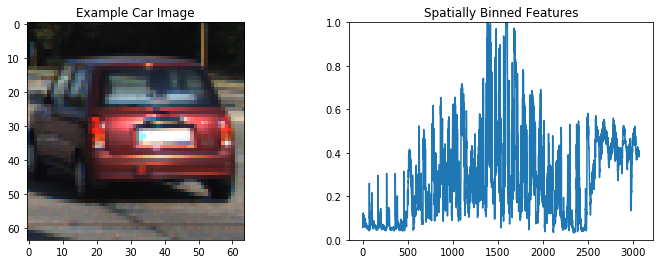

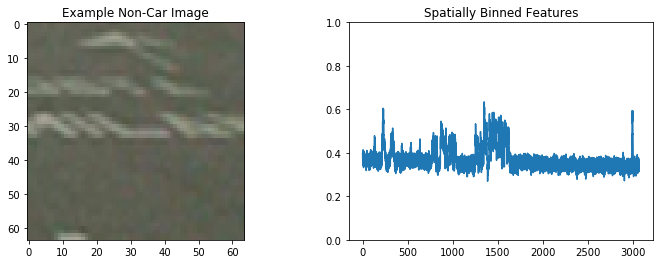

In [9]:
orig_image = mpimg.imread('test_images/training_example.png')
img = cv2.cvtColor(orig_image, cv2.COLOR_RGB2YCrCb)
image = (img * 255)

feature_vec = bin_spatial(orig_image)
fig, axes = plt.subplots(ncols=2, figsize=(12, 4))
axes[0].imshow(orig_image)
axes[0].set_title('Example Car Image')
axes[1].plot(feature_vec)
axes[1].set_ylim(bottom=0, top=1)
axes[1].set_title('Spatially Binned Features')


orig_image = mpimg.imread('test_images/non_car_example.png')
img = cv2.cvtColor(orig_image, cv2.COLOR_RGB2YCrCb)
image = (img * 255)

feature_vec = bin_spatial(orig_image)

fig, axes = plt.subplots(ncols=2, figsize=(12, 4))
axes[0].imshow(orig_image)
axes[0].set_title('Example Non-Car Image')
axes[1].plot(feature_vec)
axes[1].set_ylim(bottom=0, top=1)
axes[1].set_title('Spatially Binned Features')


## Vehicle Classifer class.
Uses SVM behind the scenes with features based on color (spatial and histogram) and Histogram of Gradients (HOG)


In [10]:
import pickle
import time
from sklearn.svm import SVC
from sklearn.svm import LinearSVC

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

class VehicleClassifier():
    ''' Vehicle Classifier class.
    '''
    
    def __init__(self):
        
        self.config = { 
            "color_space": "YCrCb",
            "orient": 12,
            "pix_per_cell": 16,
            "cell_per_block": 2,
            "hog_channel": "ALL",
            "spatial_size": (32, 32),
            "hist_bins": 32,
            "hist_bin_range": (0,1),
            "enable_spatial": True,
            "enable_hist": True,
            "enable_hog": True
        }
        
        self.cls = None
        self.scaler = None
        
    
    # Extracts features from a list of images
    def _extract_features_(self, imgs):
    
        # Create a list to append feature vectors to
        features = []
        
        # Iterate through the list of images
        for file in imgs:
            file_features = []
            
            # Read in each one by one
            image = mpimg.imread(file)
            
            # apply color conversion
            feature_image = convert_color(image, self.config["color_space"])
            
            if self.config["enable_spatial"]:
                spatial_features = bin_spatial(feature_image,
                                               size=self.config["spatial_size"])
                file_features.append(spatial_features)
            
            if self.config["enable_hist"]:
                hist_features = color_hist(feature_image, 
                                           nbins=self.config["hist_bins"],
                                           bins_range=self.config["hist_bin_range"])
                file_features.append(hist_features)
            
            if self.config["enable_hog"]:
                # Call get_hog_features() with vis=False, feature_vec=True
                if self.config["hog_channel"] == "ALL":
                    hog_features = []
                    for channel in range(feature_image.shape[2]):
                        hog_feat = get_hog_features(feature_image[:,:,channel], 
                                                    self.config["orient"],
                                                    self.config["pix_per_cell"],
                                                    self.config["cell_per_block"],
                                                    vis=False, feature_vec=True)
                        hog_features.append(hog_feat)
                    hog_features = np.ravel(hog_features)
                else:
                    hog_features = get_hog_features(feature_image[:,:,hog_channel], 
                                                    self.config["orient"],
                                                    self.config["pix_per_cell"],
                                                    self.config["cell_per_block"],
                                                    vis=False, feature_vec=True)
                
                # Append the new feature vector to the features list
                file_features.append(hog_features)
                
            features.append(np.concatenate(file_features))
        
        # Return list of feature vectors
        return features
    
    
    def train(self, car_imgs, notcar_imgs, C=1.0, kernel='linear'):
        """ Train the classifier with the lists of car and not car images.
        """
        car_features = self._extract_features_(car_imgs)
        notcar_features = self._extract_features_(notcar_imgs)
        
        X = np.vstack((car_features, notcar_features)).astype(np.float64)
        
        # Fit a per-column scaler
        self.scaler = StandardScaler().fit(X)
        
        # Apply the scaler to X
        scaled_X = self.scaler.transform(X)
        
        # Define the labels vector
        y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))
        
        # Split up data into randomized training and test sets
        rand_state = np.random.randint(0, 100)
        X_train, X_test, y_train, y_test = \
            train_test_split(scaled_X, y, test_size=0.2, random_state=rand_state)
        
        print('Using:',
              self.config["orient"],' orientations',
              self.config["pix_per_cell"],' pixels per cell and',
              self.config["cell_per_block"],' cells per block',
              ', C = ', C, ', kernel = ', kernel)
        
        print('Feature vector length:', len(X_train[0]))

        # Use a linear SVC 
        if kernel == 'linear':
            self.cls = LinearSVC(C=C)
        else:
            self.cls = SVC(C=C, kernel=kernel)
        
        # Check the training time for the SVC
        t=time.time()
        self.cls.fit(X_train, y_train)
        t2 = time.time()
        print(round(t2-t, 2), 'Seconds to train SVC...')
        
        # Check the score of the SVC
        accuracy = round(self.cls.score(X_test, y_test), 4)
        print('Test Accuracy of SVC = ', accuracy)
        
        return accuracy

    
    def find_cars(self, img, xstart, xstop, ystart, ystop, scale):
        
        img = img.astype(np.float32)/255
        
        if xstart == None:
            xstart = 0
        if xstop == None:
            xstop = img.shape[1]
        if ystart == None:
            ystart = 0
        if ystop == None:
            ystop = img.shape[0]
        
        img_tosearch = img[ystart:ystop,xstart:xstop,:]
        ctrans_tosearch = convert_color(img_tosearch, self.config["color_space"])
        
        if scale != 1:
            imshape = ctrans_tosearch.shape
            scaled_shape = (np.int(imshape[1]/scale), np.int(imshape[0]/scale))
            ctrans_tosearch = cv2.resize(ctrans_tosearch, scaled_shape)
            #img_tosearch = cv2.resize(img_tosearch, scaled_shape)

        
        #plt.imshow(img_tosearch)
        #plt.show()

        # Define blocks and steps as above
        nxblocks = (ctrans_tosearch.shape[1] // self.config["pix_per_cell"]) \
                    - self.config["cell_per_block"] + 1
        nyblocks = (ctrans_tosearch.shape[0] // self.config["pix_per_cell"]) \
                    - self.config["cell_per_block"] + 1 
        nfeat_per_block = self.config["orient"]*self.config["cell_per_block"]**2
        
        window = 64
        
        nblocks_per_window = (window // self.config["pix_per_cell"]) \
                              - self.config["cell_per_block"] + 1
        
        cells_per_step = 1  # Instead of overlap, define how many cells to step
        nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
        nysteps = (nyblocks - nblocks_per_window) // cells_per_step
        
        # Compute individual channel HOG features for the entire image
        hogs = []
        if self.config["enable_hog"]:
            for channel in range(3):
                if self.config["hog_channel"] == 'ALL' \
                   or self.config["hog_channel"] == channel:
                    hog = get_hog_features(ctrans_tosearch[:,:,channel],
                                           self.config["orient"], 
                                           self.config["pix_per_cell"],
                                           self.config["cell_per_block"],
                                           feature_vec=False)
                    hogs.append(hog)
                else:
                    hogs.append([])
    
        hot_windows = []
        for xb in range(nxsteps):
            for yb in range(nysteps):
                ypos = yb*cells_per_step
                xpos = xb*cells_per_step
                
                xleft = xpos*self.config["pix_per_cell"]
                ytop = ypos*self.config["pix_per_cell"]
                
                # Extract the image patch
                subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], 
                                    (window, window))
                
                test_features = []
                
                # Get color features
                if self.config["enable_spatial"]:
                    spatial_features = bin_spatial(subimg, size=self.config["spatial_size"])
                    test_features.append(spatial_features)
                if self.config["enable_hist"]:
                    hist_features = color_hist(subimg, nbins=self.config["hist_bins"])
                    test_features.append(hist_features)
                
                # Extract HOG features
                if self.config["enable_hog"]:
                    hog_features = []
                    for channel in range(3):
                        if len(hogs[channel]) > 0:
                            hog_feat = hogs[channel][ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
                            hog_features.append(hog_feat)
                    test_features.append(np.hstack(hog_features))
                
                test_features = self.scaler.transform(np.hstack(test_features).reshape(1, -1))    
                test_prediction = self.cls.predict(test_features)
            
                if test_prediction == 1:
                    xbox_left = np.int(xleft*scale)
                    ytop_scaled = np.int(ytop*scale)
                    win_scaled = np.int(window*scale)
                    hot_window = ((xbox_left, ytop_scaled+ystart),(xbox_left+win_scaled,ytop_scaled+win_scaled+ystart))
                    hot_windows.append(hot_window)
                
        return hot_windows

    def save(self, filename):
        vc_state = (self.config, self.cls, self.scaler)
        pickle.dump( vc_state, open( filename + ".p", "wb" ) )
    
    def load(self, filename):
        vc_state = pickle.load( open( filename + ".p", "rb" ) )
        self.config = vc_state[0]
        self.cls = vc_state[1]
        self.scaler = vc_state[2]
  


## Car Tracker class
Resonsible for finding and tracking cars in and across frames of video.
Does the "sliding window" search for vehicles in a video image frame, using the _VehicleClassifier_ to identify vehicles.   Uses matches accoss multiple frames to try and weed out false positives.

In [11]:


class CarTracker():
    '''
    Car Tracking class.
        
    Arguments:
        vehicle_classifier: VehicleClassifier (trained) to
                            use to identify cars.
        search_parms: array of tupples, each tupple consisting of:
                      0: tupple with x left/right limts.
                      1: tupple with y lower/upper limits
                      2: scale factor
        track_params: 
    '''
    def __init__(self, vehicle_classifier, search_params):
        # Classifer used to identify cars
        self.vc = vehicle_classifier
        self.search_params= search_params
        
        self.config = { 
            "min_frames_detect": 4,
            "max_frames_nodetect": 5,
            "num_heatmaps_to_keep": 4,
            "heat_threshold": 2
        }
        
        # Tracked cars.  This is an array of tupples,
        # each tupple with the following info:
        # 0 - Car ID
        # 1 - Car's current bounding box
        # 2 - Number of frames car was detected
        # 3 - Number of frames car wasn't detected
        self.tracked_cars = []
        
        # We give each detected car a unique ID.
        # This holds the next ID to assign.
        self.car_id_seq = 0
        
        self.prev_heatmaps = []
    
    def _add_heat_(self, heatmap, bbox_list):
        # Iterate through list of bboxes
        for box in bbox_list:
            # Add += 1 for all pixels inside each bbox
            # Assuming each "box" takes the form ((x1, y1), (x2, y2))
            heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1
            
        return heatmap
    
    def _add_heat_back_(self, heatmap, bbox_list):
        # Iterate through list of bboxes
        for box in bbox_list:
            # Add +=1 to any box that still has some post-threshold heat
            if np.max(heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]]) != 0:
                heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1
        
        return heatmap

    def _bboxes_from_labels_(self, labels):
        bboxes = []
        for carlabel in range(1, labels[1]+1):
            # Find pixels with each car_number label value
            nonzero = (labels[0] == carlabel).nonzero()
            
            # Identify x and y values of those pixels
            nonzeroy = np.array(nonzero[0])
            nonzerox = np.array(nonzero[1])
            
            # Define a bounding box based on min/max x and y
            bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
            bboxes.append(bbox)
        return bboxes
    
    def _bboxes_overlap_(self, bbox1, bbox2):
        """ Return true if the two boxes overlap
        """
        x1_low  = bbox1[0][0]
        x1_high = bbox1[1][0]
        y1_low  = bbox1[0][1]
        y1_high = bbox1[1][1]
        
        x2_low  = bbox2[0][0]
        x2_high = bbox2[1][0]
        y2_low  = bbox2[0][1]
        y2_high = bbox2[1][1]
        
        overlap = False
        if ((x1_low  >= x2_low and x1_low  <= x2_high) or \
            (x1_high >= x2_low and x1_high <= x2_high)) and \
           ((y1_low  >= y2_low and y1_low  <= y2_high) or \
            (y1_high >= y2_low and y1_high <= y2_high)):
                overlap = True
        elif ((x2_low  >= x1_low and x2_low  <= x1_high) or \
              (x2_high >= x1_low and x2_high <= x1_high)) and \
             ((y2_low  >= y1_low and y2_low  <= y1_high) or \
              (y2_high >= y1_low and y2_high <= y1_high)):
                overlap = True
        
        return overlap
    
    def _avg_boxes_(self, bbox1, bbox2):
        """ Return a bounding box that is an average
            of the 2 specified boxes.
        """
        x_low  = (bbox1[0][0] + bbox2[0][0])//2
        x_high = (bbox1[1][0] + bbox2[1][0])//2
        y_low  = (bbox1[0][1] + bbox2[0][1])//2
        y_high = (bbox1[1][1] + bbox2[1][1])//2
        
        return ((x_low, y_low), (x_high, y_high))
    
    def _reconcile_tracked_cars_(self, bboxes):
        """ Given a set of bounding boxes, figure out
            if they overlap with an exising tracked car
            and update its location.
            Any that doesn't overlap is assumed to be
            a new car.
        """
        
        # Loop over tracked cars, see if any bounding
        # box overlapps (detected) and update state.
        for tracked_car in self.tracked_cars:
            tracked_car_bbox = tracked_car[1]
            found = False
            for bbox in bboxes:
                if self._bboxes_overlap_(tracked_car_bbox, bbox):
                    tracked_car[1] = self._avg_boxes_(tracked_car[1], bbox)
                    if not found:
                        tracked_car[2] = tracked_car[2] + 1 # frames seen count
                        tracked_car[3] = 0 # frames not seen count
                        found = True
                    bboxes.remove(bbox)
            
            if not found:
                # No bounding box overlaps with this car (not detected)
                # Increment the "frames not scene" count
                tracked_car[3] = tracked_car[3] + 1
                if tracked_car[3] >= self.config["max_frames_nodetect"]:
                    # Forget the car if we haven't seen it in 
                    # max "no detect" number of frames.
                    self.tracked_cars.remove(tracked_car)
        
        # Any new bounding box is a new detected car
        new_cars = []
        for bbox in bboxes:
            found = False
            for new_car in new_cars:
                if self._bboxes_overlap_(bbox, new_car[1]):
                    new_car[1] = self._avg_boxes_(new_car[1], bbox)
                    found = True
            
            if not found:
                new_cars.append([0, bbox, 1, 0])
        
        self.tracked_cars = self.tracked_cars + new_cars
        
        return self.tracked_cars
    
    def draw_tracked_cars(self, img, color=(0, 0, 255), thick=4):
        """ Draw the bounding boxes of the currently tracked cars
            onto the specified image.
        """
        imcopy = np.copy(img)
        
        # Iterate through the bounding boxes
        for tracked_car in self.tracked_cars:
            # Don't draw car unless we've seen it
            # in the minimum number of frames
            if tracked_car[2] >= self.config["min_frames_detect"]:
                # If first time shown, need to assign ID.
                if tracked_car[0] == 0:
                    tracked_car[0] = self.car_id_seq
                    self.car_id_seq = self.car_id_seq + 1
                
                bbox = tracked_car[1]
                text_pos = (bbox[0][0], bbox[0][1] - 5)
                
                # Draw a rectangle given bbox coordinates
                cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
                cv2.putText(imcopy,
                            "Car " + str(tracked_car[0]), text_pos,
                            cv2.FONT_HERSHEY_SIMPLEX, .6, color, 2)
        
        # Return the image copy with boxes drawn
        return imcopy

    def find_cars(self, img, vis=False):
        """ Find cars in the specified image.
        """
        
        hot_windows = []
        for search_param in self.search_params:
            found_windows = self.vc.find_cars(img, 
                                              search_param[0][0], search_param[0][1],
                                              search_param[1][0], search_param[1][1],
                                              search_param[2])
            hot_windows = hot_windows + found_windows
        
        heat = np.zeros_like(img[:,:,0]).astype(np.float)
        
        # Add heat to each box in box list
        heat = self._add_heat_(heat, hot_windows)
        
        heatmap_no_threshold = None
        if vis == True:
            heatmap_no_threshold = np.clip(heat, 0, 255)
        
        if len(self.prev_heatmaps) >= self.config["num_heatmaps_to_keep"]:
            self.prev_heatmaps = self.prev_heatmaps[1:]
        
        self.prev_heatmaps.append(heat)
        
        heat = np.zeros_like(img[:,:,0]).astype(np.float)
        for prev_heatmap in self.prev_heatmaps:
            heat = np.add(heat, prev_heatmap)
        
        heat = heat // len(self.prev_heatmaps);
        
        avg_heatmap_no_threshold = None
        if vis == True:
            avg_heatmap_no_threshold = np.clip(heat, 0, 255)
            
        # Apply threshold to help remove false positives
        heat[heat <= self.config["heat_threshold"]] = 0
        
        # Put heat back in windows that overlap pixels
        # that survied the threshold.  This helps to
        # size the bounding box to the detected car.
        heat = self._add_heat_back_(heat, hot_windows)
        
        heatmap = np.clip(heat, 0, 255)
        
        # Find final boxes from heatmap using label function
        labels = label(heatmap)
        
        bboxes = self._bboxes_from_labels_(labels)
        
        self._reconcile_tracked_cars_(bboxes)
        
        if vis == True:
            return self.tracked_cars, hot_windows, heatmap_no_threshold, avg_heatmap_no_threshold
        else:
            return self.tracked_cars


## Search Windows
Visualize what search windows we will use to search for cars.

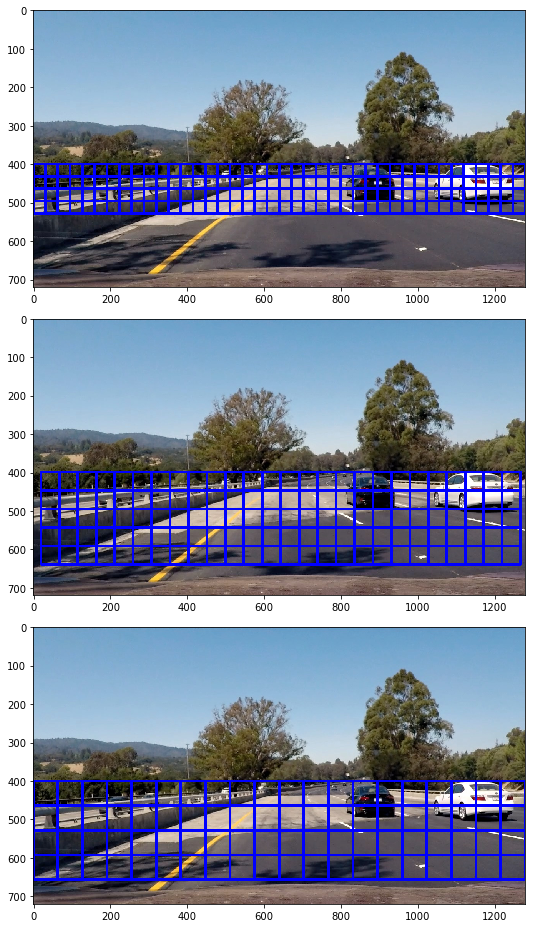

In [13]:
image = mpimg.imread('test_images/test4.jpg')

window_sm = slide_window(image, 
                          x_start_stop=[None, None], y_start_stop=[400, 550], 
                          xy_window=(64, 64), xy_overlap=(0.5, 0.5))

window_md = slide_window(image,
                          x_start_stop=[20, None], y_start_stop=[400, 650], 
                          xy_window=(int(64 * 1.5), int(64 * 1.5)), xy_overlap=(0.5, 0.5))

window_lg = slide_window(image,
                          x_start_stop=[None, None], y_start_stop=[400, 710], 
                          xy_window=(int(64 * 2), int(64 * 2)), xy_overlap=(0.5, 0.5))

window_img_sm = draw_boxes(image, window_sm, color=(0, 0, 255), thick=6)
window_img_md = draw_boxes(image, window_md, color=(0, 0, 255), thick=6)
window_img_lg = draw_boxes(image, window_lg, color=(0, 0, 255), thick=6)

fig, axes = plt.subplots(nrows=3, figsize=(27, 13))
axes[0].imshow(window_img_sm)
axes[1].imshow(window_img_md)
axes[2].imshow(window_img_lg)
fig.tight_layout()
plt.show()


## Train the VehicleClassifier
Train the VehicleClassifier using various hyper-parameters.  We'll use the one with the highest accuracy but still provices sub-second prection time.

In [14]:
# test image to determine 
test_img = mpimg.imread('test_images/test6.jpg')

def try_params(orient, pix_per_cell, C, kernel):
    vc = VehicleClassifier()
    vc.config['orient'] = orient
    vc.config['pix_per_cell'] = pix_per_cell
    
    accuracy = vc.train(cars, notcars, C=C, kernel=kernel)
    
    t=time.time()
    vc.find_cars(test_img, None, None, 400, 500, 1)
    t2 = time.time()
    
    detect_time = round(t2-t, 2)
    
    return vc, accuracy, detect_time

results = []
for orient in [8, 10, 12]:
    for pix_per_cell in [8,16]:
        for C in [0.5, 1.0, 2.0]:
            vc, acc, tm = try_params(orient, pix_per_cell, C, 'linear')
            vc.save("vc_state_" + str(orient) + "_" + str(pix_per_cell) + "_" + str(C) + "_linear")
            results.append((orient, pix_per_cell, C, 'linear', acc, tm))

for kernel in ['rbf', 'poly']
    for orient in [8, 10, 12]:
        pix_per_cell = 16
        C = 1
        vc, acc, tm = try_params(orient, pix_per_cell, C, kernel)
        vc.save("vc_state_" + str(orient) + "_" + str(pix_per_cell) + "_" + str(C) + "_" + kernel)
        results.append((orient, pix_per_cell, C, kernel, acc, tm))


print("Orient, Pix/Cell, C, Kernel, Accuracy, Prediction Time")
sorted_results = sorted(results, key=lambda result: result[4], reverse=True)
best_result = None
for result in sorted_results:
    print("%d, %d, %2.1f, %s, %0.4f, %3.2f" % result)
    if best_result is None and result[5] < .5:
        best_result = result

print("")
print("Fastest/Best = (%d, %d, %2.1f, %s, %0.4f, %3.2f)" % best_result)


Orient, Pix/Cell, C, Kernel, Accuracy, Prediction Time
12, 16, 1.0, rbf, 0.9955, 1.59
8, 16, 1.0, rbf, 0.9944, 1.63
12, 8, 0.5, linear, 0.9941, 0.61
10, 16, 1.0, rbf, 0.9933, 1.53
12, 16, 1.0, linear, 0.9924, 0.19
8, 8, 1.0, linear, 0.9921, 0.51
8, 8, 0.5, linear, 0.9907, 0.53
10, 8, 1.0, linear, 0.9907, 0.55
12, 16, 1.0, poly, 0.9907, 3.52
8, 16, 0.5, linear, 0.9904, 0.16
12, 8, 2.0, linear, 0.9904, 0.58
12, 16, 0.5, linear, 0.9904, 0.19
10, 16, 2.0, linear, 0.9902, 0.17
12, 16, 2.0, linear, 0.9902, 0.18
8, 16, 2.0, linear, 0.9899, 0.16
12, 8, 1.0, linear, 0.9899, 0.62
10, 16, 1.0, poly, 0.9899, 3.32
8, 16, 1.0, linear, 0.9893, 0.16
10, 16, 1.0, linear, 0.9893, 0.17
8, 8, 2.0, linear, 0.9888, 0.51
10, 8, 0.5, linear, 0.9888, 0.61
10, 8, 2.0, linear, 0.9885, 0.56
10, 16, 0.5, linear, 0.9876, 0.16
8, 16, 1.0, poly, 0.9831, 3.16

Fastest/Best = (12, 16, 1.0, linear, 0.9924, 0.19)


### Classification Examples
Run the previously found "best" classifier on test images.

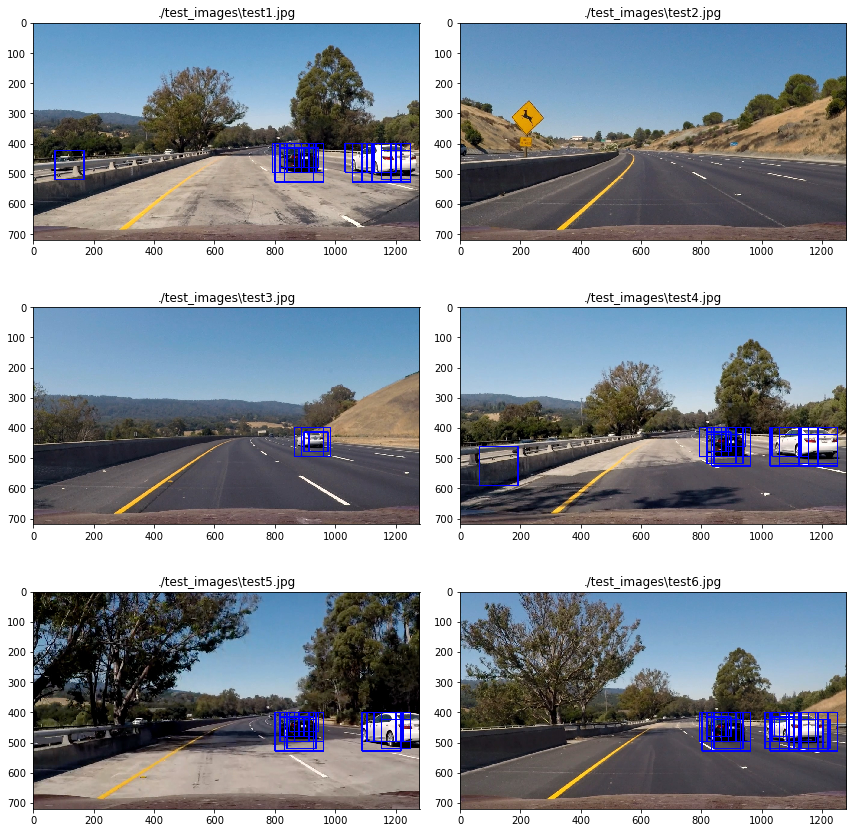

In [15]:
vc = VehicleClassifier()
vc.load("vc_state_12_16_1.0_linear")
    
search_params = [((None, None), (400, 500), 1),
                 ((None, None), (400, 650), 1.5),
                 ((None, None), (400, 700), 2)]

tracker = CarTracker(vc, search_params)
tracker.config["min_frames_detect"] = 1
tracker.config["max_frames_nodetect"] = 0
tracker.config["heat_threshold"] = 1
tracker.config["num_heatmaps_to_keep"] = 1

fig, axes = plt.subplots(ncols=2, nrows=3, figsize=(12, 12))

images = glob.glob('./test_images/test*.jpg')
for idx, image_file_name in enumerate(images):
    img = mpimg.imread(image_file_name)
    found_cars, hot_boxes, heatmap, avg_heatmap = tracker.find_cars(img, vis=True)
    
    axes[idx//2][idx%2].imshow(draw_boxes(img, hot_boxes, color=(0, 0, 255), thick=4))
    axes[idx//2][idx%2].set_title(image_file_name)
fig.tight_layout()
plt.show()


### False Positive Removal (Heat Map Averaging) Example
Example of 4 frames of video with heat map averaging.

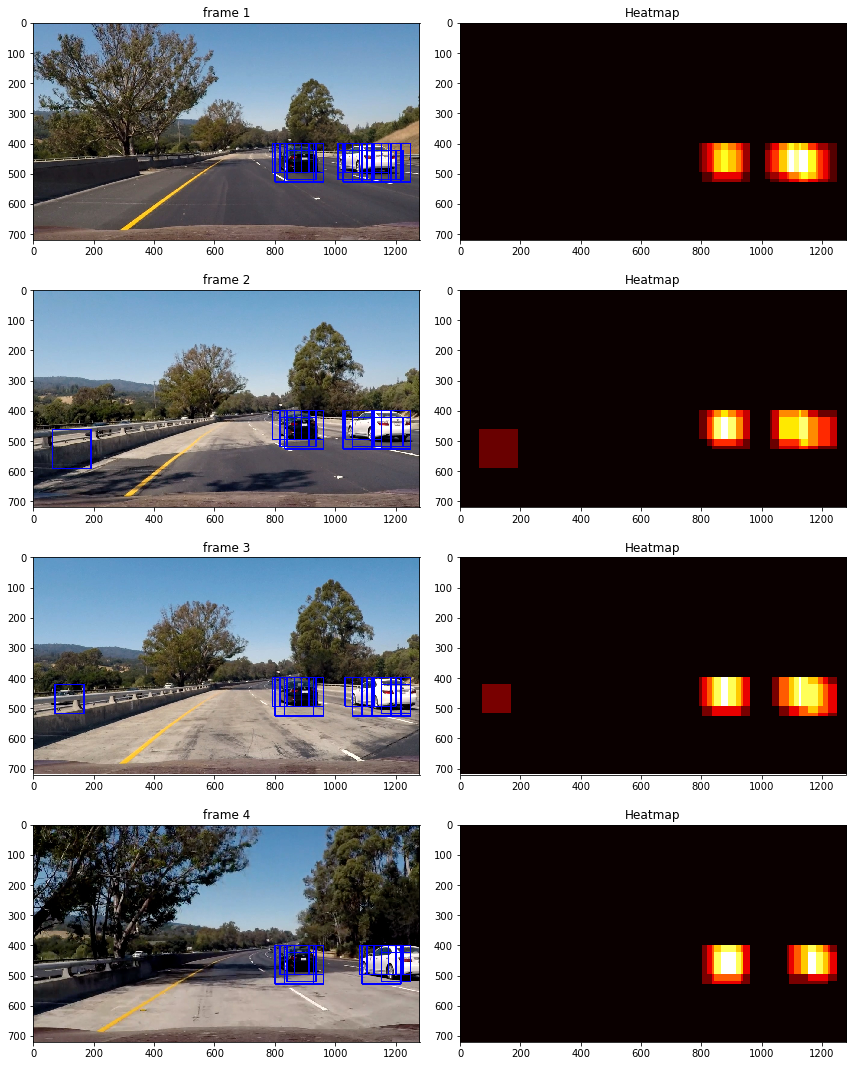

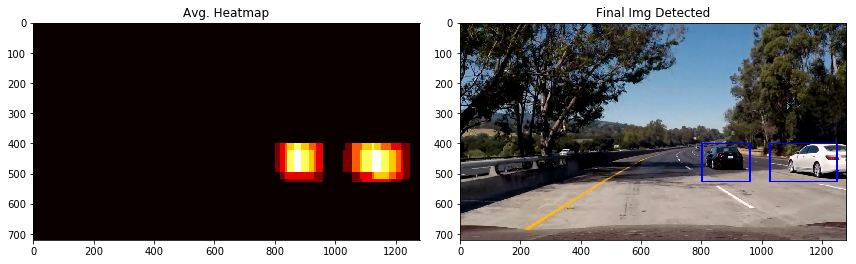

In [16]:
vc = VehicleClassifier()
vc.load("vc_state_12_16_1.0_linear")

search_params = [((200, 400), (400, 720), 1),
                 ((None, None), (400, 720), 1.5),
                 ((None, None), (400, 720), 2)]

tracker = CarTracker(vc, search_params)
tracker.config["min_frames_detect"] = 1
tracker.config["max_frames_nodetect"] = 0
tracker.config["heat_threshold"] = 1

# Average heat maps over previous 4 frames
tracker.config["num_heatmaps_to_keep"] = 4

fig, axes = plt.subplots(ncols=2, nrows=4, figsize=(12, 15))

img = avg_heatmap = None
for idx, img_num in enumerate([6, 4, 1, 5]):
    filename = "test%d.jpg" % img_num
    img = mpimg.imread('test_images/' + filename)
    found_cars, hot_boxes, heatmap, avg_heatmap = tracker.find_cars(img, vis=True)
    axes[idx][0].imshow(draw_boxes(img, hot_boxes, color=(0, 0, 255), thick=4))
    axes[idx][0].set_title("frame " + str(idx + 1))
    axes[idx][1].imshow(heatmap, cmap='hot')
    axes[idx][1].set_title("Heatmap")
fig.tight_layout()
plt.show()

labels = label(avg_heatmap)
bboxes = tracker._bboxes_from_labels_(labels)

fig, axes = plt.subplots(ncols=2, figsize=(12, 15))
axes[0].imshow(avg_heatmap, cmap='hot')
axes[0].set_title("Avg. Heatmap")
axes[1].imshow(draw_boxes(img, bboxes, color=(0, 0, 255), thick=4))
axes[1].set_title("Final Img Detected")
fig.tight_layout()
plt.show()


## Car Finder closures
Closers that instantiate stateful *VehicleClassifier* and *CarFinder* objects and return a method to process an image.

__Note__ there are 2 versions:
1. *get_car_finder* is vehicle detection only.
2. *get_car_and_lane_finder* combines vehicle detection with lane detection.


In [17]:
# Car Finder (without Lane Detection)
def get_car_finder():
    
    vc = VehicleClassifier()
    vc.load("vc_state_12_16_1.0_linear")
    
    search_params = [((None, None), (400, 500), 1),
                     ((20, None), (400, 625), 1.5),
                     ((None, None), (400, 650), 2)]
    
    ct = CarTracker(vc, search_params)
    
    transform = ld.Transform()
    transform.load("transform_state")

    def process_image(image):
        tracked_cars = ct.find_cars(image)
        window_img = ct.draw_tracked_cars(image, color=(0, 0, 255), thick=4)
        return window_img

    return process_image



# Car Finder w/ Lane Detection
import lane_detection as ld
def get_car_and_lane_finder():
    vc = VehicleClassifier()
    vc.load("vc_state_12_16_1.0_linear")

    # search windows that work for undistorted images
    search_params = [((None, None), (375, 480), 1),
                     ((20, None), (380, 610), 1.5),
                     ((None, None), (400, 660), 2)]
        
    ct = CarTracker(vc, search_params)
    
    transform = ld.Transform()
    transform.load("transform_state")
    
    lane_finder = ld.get_lane_finder(transform)

    def process_image(image):
        
        undistorted_img = transform.remove_distortion(image)
        
        tracked_cars = ct.find_cars(undistorted_img)
        lane, lane_colorized = lane_finder(undistorted_img)
        
        final_image = undistorted_img
        
        if lane_colorized is not None:
            final_image = cv2.addWeighted(final_image, 1, lane_colorized, 0.3, 0)
        
        final_image = ct.draw_tracked_cars(final_image, color=(0, 0, 255), thick=4)
        
        if lane.has_best_fit():
            curvature_msg = "Radius of Curvature is {0:.0f}(m)".format(lane.get_radius_of_curvature())
            offset = lane.get_offset_from_center()
            if offset < 0:
                offset_msg = "Vehicle is {0:.3f}m left of center".format(abs(offset))
            elif offset > 0:
                offset_msg = "Vehicle is {0:.3f}m right of center".format(offset)
            else:
                offset_msg = "Vehicle is centered"
            
            cv2.putText(final_image, curvature_msg, (100,100), cv2.FONT_HERSHEY_SIMPLEX, 2, (255, 255, 255), 1)
            cv2.putText(final_image, offset_msg, (100,200), cv2.FONT_HERSHEY_SIMPLEX, 2, (255, 255, 255), 1)
        
        else:
            cv2.putText(final_image, "No Lane Detected", (100,100), cv2.FONT_HERSHEY_SIMPLEX, 2, (255, 255, 255), 1)
        
        
        return final_image

    return process_image

## Process Test Video
Test video is 1 second subclip of the project video.  This test only includes vehichle detection.

In [18]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

video_output = 'test_video_out.mp4'
clip1 = VideoFileClip("test_video.mp4")
video_clip = clip1.fl_image(get_car_finder()) #NOTE: this function expects color images!!
video_clip.write_videofile(video_output, audio=False)
clip1.__del__()
video_clip.__del__()

[MoviePy] >>>> Building video test_video_out.mp4
[MoviePy] Writing video test_video_out.mp4


 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌   | 38/39 [00:19<00:00,  1.99it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_video_out.mp4 



## Process Project Video
Includes both Vehicle Dection and Lane Detection

In [19]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

video_output = 'project_video_out.mp4'
clip1 = VideoFileClip("project_video.mp4")
video_clip = clip1.fl_image(get_car_and_lane_finder()) #NOTE: this function expects color images!!
video_clip.write_videofile(video_output, audio=False)
clip1.__del__()
video_clip.__del__()

[MoviePy] >>>> Building video project_video_out.mp4
[MoviePy] Writing video project_video_out.mp4


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉| 1260/1261 [15:33<00:00,  1.33it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_out.mp4 

